In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

# Task A

*What is the main assumption that makes RDD possible? Define the local randomization condition in the simplified setup presented in the lecture.*

Main assumption: agents are unable to precisely control the assignment variable near the known cutoff what leads to the randomized variation in treatment near the threshold.

local randomization.

The framework:
$$Y = D \tau + W \delta_1 + U$$
$$D = I(X \geq c)$$
$$X = W \delta_2 + V,$$

where:
- Y is the outcome of interest, 
- D is the binary treatment indicator, 
- W is the vector of all predetermined and observable characteristics of the individual that might impact Y and/or X,
- X is the assignment variable,
- c is the cutoff value

Individuals have imprecise control over X when conditional on W = w and U = u, the density of V (and hence X) is continuous. 

*Definition of Local Randomization:* if individuals have imprecise control over X, then Pr\[W = w,U = u|X = x\] is continuous in x: the treatment is “as good as” randomly assigned around the cutoff.

# Task B.1

*Create a new variable that groups the assignment variable values into 400 bins with a size of 0.005*

In [3]:
df = pd.read_stata('data/individ_final.dta')
bins = np.linspace(-1, 1, num=401)
labels =  np.linspace(0, 399, num=400)
df['bin'] = pd.cut(df.difshare, bins, labels = labels,include_lowest = True)
df['bin'] = pd.to_numeric(df['bin'])
df = df.sort_values(by='bin')
df

,year,outcome,outcomenext,difshare,bin
18067,1960,0,-1,-0.998273,0.0
17946,1962,0,-1,-0.999653,0.0
17947,1962,0,-1,-0.999653,0.0
17948,1962,0,-1,-0.999653,0.0
17949,1962,0,-1,-0.999653,0.0
...,...,...,...,...,...
15841,1954,1,1,0.999922,399.0
18050,1960,1,1,0.997548,399.0
20564,1960,1,1,0.999951,399.0
16413,1946,1,1,0.996996,399.0


# Task B.2

*Since we are interested in a causal influence on the probability that the candidate will win the next election based on winning the current election, drop the rows that do not have a comparable next election.*

In [4]:
df = df[(df['outcomenext'] == 1) | (df['outcomenext'] == 0) ]
df

,year,outcome,outcomenext,difshare,bin
13050,1952,0,0,-0.996721,0.0
16761,1946,0,0,-0.999268,0.0
23171,1968,0,0,-0.901280,19.0
15113,1968,0,0,-0.853781,29.0
14899,1980,0,0,-0.809648,38.0
...,...,...,...,...,...
15841,1954,1,1,0.999922,399.0
18050,1960,1,1,0.997548,399.0
20564,1960,1,1,0.999951,399.0
16413,1946,1,1,0.996996,399.0


# Task B.3

*Find the mean of the outcome variable for each bin or, in other words, local average. Draw this relationship on the scatterplot.*

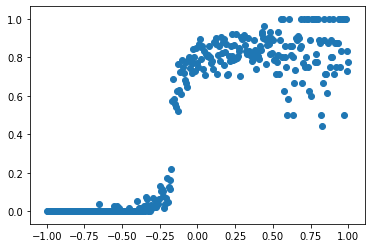

In [8]:
dfm = df.groupby('bin').mean()
x = np.linspace(-1, 1, num=342)
plt.scatter(x, dfm['outcomenext'])

# Task B.4

*For better visuality we also add to the graph the fitted values of logistic regression around the cutoff. For this apply logistic regression separately on either side of the threshold (we take the bins with the share values from -0.25 to 0.25 and use the package LogisticRegression from sklearn.linear_model). Extract probability estimates. Add them to the scatterplot in the proximity of cutoff. Do you observe a discontinuity at the cutoff point?*

C:\Users\liudm\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\liudm\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\liudm\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\Users\liudm\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


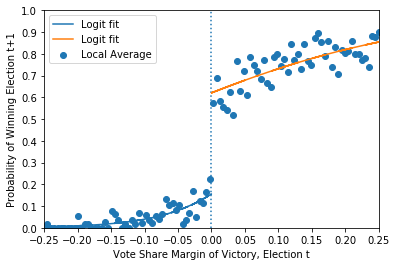

In [11]:
#split the sample into two parts before and after cutoff
df_left = df[(df['difshare'] >= -0.25) & (df['difshare'] < 0) ]
df_right = df[(df['difshare'] >= 0) & (df['difshare'] <= 0.25) ]
x_left = df_left['difshare'].values.reshape(-1, 1)
y_left = df_left['outcomenext'].values.reshape(-1, 1)
x_right = df_right['difshare'].values.reshape(-1, 1)
y_right = df_right['outcomenext'].values.reshape(-1, 1)

#apply Logistic Regression and extract propensity score
lr_left = LogisticRegression(solver = 'newton-cg', C=1e20)
lr_left.fit(x_left, y_left)
prob_left = lr_left.predict_proba(x_left)[:, 1]
lr_right = LogisticRegression(solver = 'newton-cg', C=1e20)
lr_right.fit(x_right, y_right)
prob_right = lr_right.predict_proba(x_right)[:, 1]

#draw the plot
fig, ax = plt.subplots()
ax.set_xlim(-0.25, 0.25)
ax.set_xticks(np.arange(-0.25, 0.251, step=0.05))
ax.set_ylim(0.0, 1.0)
ax.set_yticks(np.arange(0.0, 1.01, step=0.1))
dfm = dfm[(dfm['difshare'] >= -0.25) & (dfm['difshare'] <= 0.25) ]
x = np.linspace(-0.25, 0.25, num=100)
ax.scatter(x, dfm['outcomenext'], label = 'Local Average')
ax.axvline(0.0, linestyle = ':')
ax.plot(x_left, prob_left, label = 'Logit fit')
ax.plot(x_right, prob_right, label = 'Logit fit')
ax.set_xlabel('Vote Share Margin of Victory, Election t')
ax.set_ylabel('Probability of Winning Election t+1')
ax.legend()

plt.show()

# Task C

*Run the LLR with a specification $Y = \alpha_r + \tau D + \beta X + \gamma X D + \epsilon$, where X is rectricted by a bandwidth: $h \geq X \geq -h$. Interpret the result. Experiment with few bandwidths on your choice.*

In [12]:
for h in [0.25, 0.2, 0.1, 0.05, 0.01]:
    dfreg = df[df['difshare'].between(-h, h)]
    rslt = smf.ols(formula='outcomenext ~ outcome + difshare + difshare*outcome', data=dfreg).fit()
    info = [h, rslt.params[1] * 100, rslt.pvalues[1]]
    print(' Bandwidth: {:>4}   Effect {:5.3f}%    pvalue {:5.3f}'.format(*info))

 Bandwidth: 0.25   Effect 52.439%    pvalue 0.000
 Bandwidth:  0.2   Effect 49.521%    pvalue 0.000
 Bandwidth:  0.1   Effect 43.861%    pvalue 0.000
 Bandwidth: 0.05   Effect 38.910%    pvalue 0.000
 Bandwidth: 0.01   Effect 25.700%    pvalue 0.069


# Task D

*If you want to practice your Python skills, we recommend to work with the packages LeaveOneOut() and cross_val_score from sklearn.model_selection and to write the code that finds the optimal bandwidth. Otherwise, we created the file auxiliary.py with a solution. Use it to draw the graph showing the relationship between the bandwidth and the mean square error. What is the optimal bandwidth for LLR in our framework?*

In [5]:
# create two sides around the cutoff
df_right = df
df_left = df[(df['difshare'] >= -0.5) & (df['difshare'] < 0) ]
df_right = df_right[(df_right['difshare'] >= 0) & (df_right['difshare'] <= 0.5) ]
# create necessary arrays
position = np.linspace(0, 99, num=100).astype(int)
width_left = np.linspace(199, 100, num=100).astype(int)
error_mean_left = np.linspace(0, 0, num=100)
width_right = np.linspace(200, 299, num=100).astype(int)
error_mean_right = np.linspace(0, 0, num=100)
#run cross-validation on each side
for h, p in zip(width_left, position):
    dfreg = df_left[(df_left['bin'] >= h)]
    X = dfreg['difshare'].values.reshape(-1, 1)
    y = dfreg['outcomenext'].values.reshape(-1, 1)
    loocv = LeaveOneOut()
    model = LinearRegression()
    results = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=loocv)
    error_mean_left[p] = results.mean()*(-1)
for h, p in zip(width_right, position):
    dfreg = df_right[(df_right['bin'] <= h)]
    X = dfreg['difshare'].values.reshape(-1, 1)
    y = dfreg['outcomenext'].values.reshape(-1, 1)
    loocv = LeaveOneOut()
    model = LinearRegression()
    results = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=loocv)
    error_mean_right[p] = results.mean()*(-1)

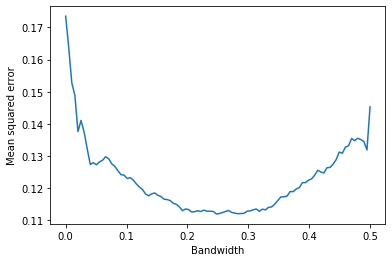

In [12]:
#find mean error on both sides of the cutoff and plot it
error_mean_right_corr = error_mean_right[::-1]
error = (error_mean_left + error_mean_right_corr)/2
bandwidth = np.linspace(0, 0.5, num=100)
fig, ax = plt.subplots()
ax.plot(bandwidth, error)
ax.set_xlabel('Bandwidth')
ax.set_ylabel('Mean squared error')
plt.show()

In [13]:
df = pd.DataFrame({'bandwidth': bandwidth, 'error': error}, columns=['bandwidth', 'error'])
df = df[df.error == df.error.min()]
print(' Optimal bandwidth: {:5.3f}'.format(df.iloc[0,0])) 

 Optimal bandwidth: 0.247
